This based off of the tutorial from scanpy using pbmc 3K.
https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html

And heavily influenced by https://github.com/theislab/scanpy_usage/blob/master/170503_zheng17/zheng17.ipynb

# Imports

In [1]:
# general imports
import warnings
import numpy as np
import os
import pandas as pd
import scipy as sp
from scipy.sparse import coo_matrix
import collections
import scanpy as sc


# Images, plots, display, and visualization
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.manifold import TSNE
import sklearn as sk

# matplotlib settings for Jupyter notebooks only
%matplotlib inline

import pickle
import gzip
from pathlib import Path


# Parameters

In [4]:
# parameters

aug_data_path = f"{os.getcwd()}/../data/single_cell_data/augmented_pbmc_data/"
cybersort_path = f"{os.getcwd()}/../data/single_cell_data/cybersort_pbmc/"
data_path = f"{os.getcwd()}/../data/single_cell_data/pbmc68k/hg19/"
scpred_path = f"{os.getcwd()}/../results/single_cell_data/pbmc_cell_labels/"


num_cells_vec = [500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000]


#####################
### set the study ###
#####################

res_name = "pbmc68k"
results_file = f"{data_path}/{res_name}.h5ad"



# Load and Process data

### Read in data and metadata

In [5]:
# read in the data

adata = sc.read_10x_mtx(
    data_path,                               # the directory with the `.mtx` file
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=True)                              # write a cache file for faster subsequent reading

adata.var_names_make_unique()  # this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`



In [9]:
# add metadata

# add metadata
meta_data = pd.read_csv(f"{scpred_path}/{res_name}_scpred.tsv", sep="\t", index_col='code')
barcodes = pd.read_csv(f"{data_path}/barcodes.tsv", header=None, names=['code'])
meta_df = barcodes.join(other=meta_data, on=['code'], how='left', sort=False)


adata.obs['CellType'] = meta_df['cell_type'].tolist()
adata.obs['scpred_CellType'] = meta_df['scpred_prediction'].tolist()


### Preprocess

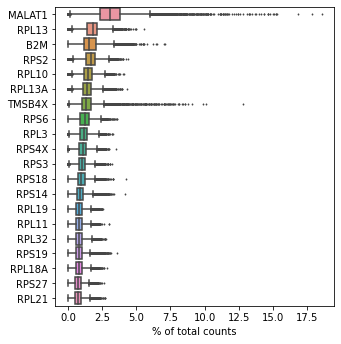

In [10]:
sc.pl.highest_expr_genes(adata, n_top=20, )


In [11]:
# filter out cells with less than 200 genes and genes expressed in less than 3 cells
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'CellType' as categorical
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'scpred_CellType' as categorical


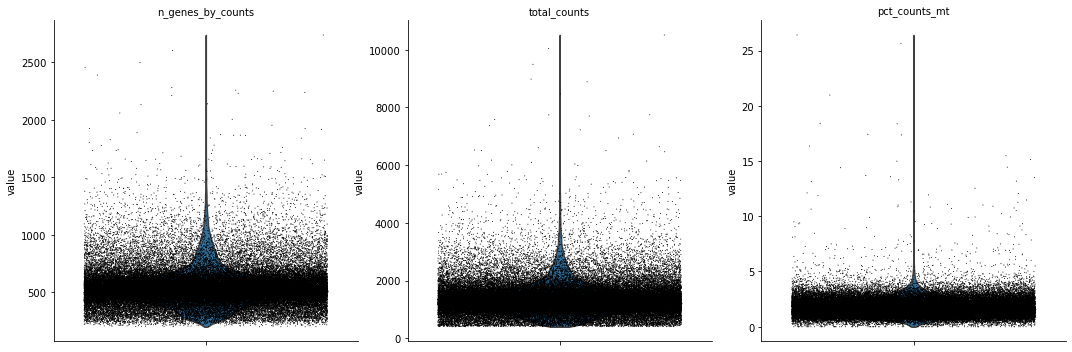

In [12]:
# remove genes with high mitochondrial content
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

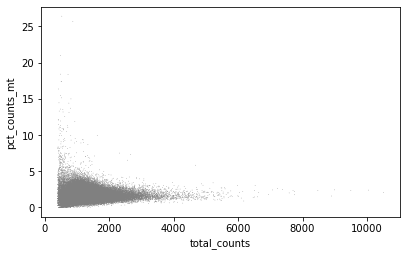

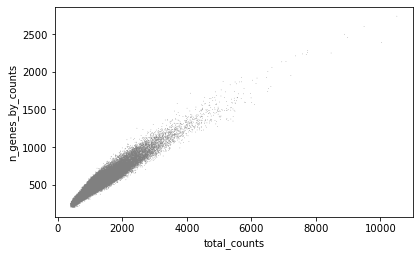

In [13]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

In [14]:
# slice the data based on the plots from above
# remove cells with more than 3500 genes
# remove cells with more than 10% MTgenes
adata = adata[adata.obs.n_genes_by_counts < 2000, :]
adata = adata[adata.obs.pct_counts_mt < 10, :]


# normalize to 10K counts per cell
sc.pp.normalize_total(adata, target_sum=1e4)


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [17]:
# remove cells that are unlabeled or unclassified
cell_type_id = adata.obs["scpred_CellType"].values.unique()
cell_type_remove = ["unassigned", "unclassified"]
cell_type_id = set(cell_type_id).difference(set(cell_type_remove))
adata = adata[adata.obs["scpred_CellType"].isin(cell_type_id)]
print(adata.obs["scpred_CellType"].values.unique())

['cd8', 'cd8naive', 'cd4', 'bnaive', 'cd4naive', ..., 'mono14', 'mono16', 'bmem', 'mk', 'hsc']
Length: 13
Categories (13, object): ['adc', 'bmem', 'bnaive', 'cd4', ..., 'mono14', 'mono16', 'nk', 'pdc']


In [22]:
# write out data for BP and cibersort
dense_matrix = adata.X.todense()

sc_profile_file = os.path.join(aug_data_path, f"{res_name}_sig.pkl")
sc_profile_path = Path(sc_profile_file)
pickle.dump( dense_matrix, open( sc_profile_path, "wb" ) )


In [24]:
dense_matrix.shape

(61409, 17788)

# Plot Data

         Falling back to preprocessing with `sc.pp.pca` and default params.


OMP: Info #273: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


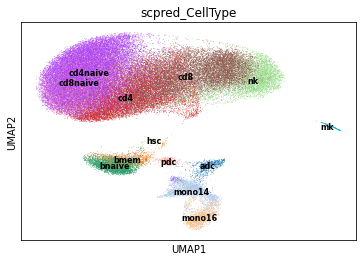

In [16]:
# valculate neighborhood graph
sc.pp.neighbors(adata)

# make umap
sc.tl.umap(adata)

# plot some markers of the RAW data
sc.pl.umap(adata, legend_loc='on data', color='scpred_CellType', legend_fontsize=8)


# Make Pseudobulks

In [18]:
# write out all the methods

# cell type specific pseudobulk
def get_cell_type_sum(in_adata, cell_type_id, num_samples):
  cell_df = in_adata[in_adata.obs["scpred_CellType"].isin([cell_type_id])]
  cell_sample = sk.utils.resample(cell_df, n_samples = num_samples, replace=True)
  sum_per_gene = cell_sample.X.sum(axis=0)

  return sum_per_gene

# method to generate a proportion vector
def gen_prop_vec_lognormal(len_vector, num_cells):

  rand_vec = np.random.lognormal(5, np.random.uniform(1,3), len_vector) # 1

  rand_vec = np.round((rand_vec/np.sum(rand_vec))*num_cells)
  if(np.sum(rand_vec) != num_cells):
    idx_change = np.argmax(rand_vec)
    rand_vec[idx_change] = rand_vec[idx_change] + (num_cells - np.sum(rand_vec))

  rand_vec = rand_vec.astype(int)
  
  return rand_vec

# method to generate true proportion vector
def true_prop_vec(in_adata, num_cells):

  rand_vec = in_adata.obs["scpred_CellType"].value_counts() / in_adata.obs["scpred_CellType"].shape[0]
  rand_vec = np.array(rand_vec)

  rand_vec = np.round(rand_vec*num_cells)
  if(np.sum(rand_vec) != num_cells):
    idx_change = np.argmax(rand_vec)
    rand_vec[idx_change] = rand_vec[idx_change] + (num_cells - np.sum(rand_vec))

  rand_vec = rand_vec.astype(int)
  
  return rand_vec

# total pseudobulk
def make_prop_and_sum(in_adata, num_samples, num_cells, use_true_prop):
  len_vector = in_adata.obs["scpred_CellType"].unique().shape[0]

  # instantiate the expression and proportion vectors
  total_expr = pd.DataFrame(columns = in_adata.var['gene_ids'])
  total_prop = pd.DataFrame(columns = in_adata.obs["scpred_CellType"].unique())

  # sample specific noise
  sample_noise = np.random.lognormal(0, 0.1, in_adata.var['gene_ids'].shape[0])

  # cell specific noise
  cell_noise = [np.random.lognormal(0, 0.1, in_adata.var['gene_ids'].shape[0]) for i in range(len_vector)]

  # iterate over all the samples we would like to make
  for samp_idx in range(num_samples):
    if samp_idx % 100 == 0:
      print(samp_idx)

    if use_true_prop:
      props_vec = true_prop_vec(in_adata, num_cells)
    else:
      props_vec = gen_prop_vec_lognormal(len_vector, num_cells)
    props = pd.DataFrame(props_vec)
    props = props.transpose()
    props.columns = in_adata.obs["scpred_CellType"].unique()
    total_prop = total_prop.append(props)

    sum_over_cells = np.zeros(in_adata.var['gene_ids'].shape[0])


    #iterate over all the cell types
    for cell_idx in range(len_vector):
      cell_type_id = in_adata.obs["scpred_CellType"].unique()[cell_idx]
      num_cell = props_vec[cell_idx]
      ct_sum = get_cell_type_sum(in_adata, cell_type_id, num_cell)

      # add noise
      if not use_true_prop:
        ct_sum = np.multiply(ct_sum, cell_noise[cell_idx])
      sum_over_cells = sum_over_cells + ct_sum

    sum_over_cells = pd.DataFrame(sum_over_cells)
    sum_over_cells.columns = in_adata.var['gene_ids']

    # add sample noise
    if not use_true_prop:
      sum_over_cells = np.multiply(sum_over_cells, sample_noise)

    total_expr = total_expr.append(sum_over_cells)


  return (total_prop, total_expr)



In [19]:
# write out the gene ids
gene_pass = adata.var['gene_ids']
gene_out_file = os.path.join(aug_data_path, f"{res_name}_genes.pkl")
gene_out_path = Path(gene_out_file)
pickle.dump( gene_pass, open( gene_out_path, "wb" ) )


# simulate different number of cells
num_samples = 1000
for idx in range(len(num_cells_vec)):
  print(f"New Domain {idx}")
  pbmc_rep1_pseudobulk_file = os.path.join(aug_data_path, f"{res_name}_pseudo_{idx}.pkl")
  pbmc_rep1_prop_file = os.path.join(aug_data_path, f"{res_name}_prop_{idx}.pkl")

  pseudobulk_path = Path(pbmc_rep1_pseudobulk_file)
  prop_path = Path(pbmc_rep1_prop_file)

  if not pseudobulk_path.is_file(): # skip if we already generated it

    # make the pseudobulks
    num_cells = num_cells_vec[idx]
    prop_df, pseudobulks_df = make_prop_and_sum(adata, 
                                                num_samples, 
                                                num_cells,
                                                use_true_prop=False)

    # make the proportions instead of cell counts
    prop_df = prop_df.div(prop_df.sum(axis=1), axis=0)

    pickle.dump( prop_df, open( prop_path, "wb" ) )
    pickle.dump( pseudobulks_df, open( pseudobulk_path, "wb" ) )


    if not np.all(np.isclose(prop_df.sum(axis=1), 1.)):
        assert False, "Proportions do not sum to 1"



New Domain 0
0
100
200
300
400
500
600
700
800
900
New Domain 1
0
100
200
300
400
500
600
700
800
900
New Domain 2
0
100
200
300
400
500
600
700
800
900
New Domain 3
0
100
200
300
400
500
600
700
800
900
New Domain 4
0
100
200
300
400
500
600
700
800
900
New Domain 5
0
100
200
300
400
500
600
700
800
900
New Domain 6
0
100
200
300
400
500
600
700
800
900
New Domain 7
0
100
200
300
400
500
600
700
800
900
New Domain 8
0
100
200
300
400
500
600
700
800
900
New Domain 9
0
100
200
300
400
500
600
700
800
900
